In [1]:
import sys
sys.path.append('..')

In [2]:
import gc 

import torch

import numpy as np

import models
import custom_transforms
from datasets.sequence_folders import SequenceFolder
from radar_eval.eval_utils import RadarEvalOdom

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'TITAN V'

In [4]:
weights_pose = torch.load("../checkpoints/resnet50_depth_256/02-02-09:46/exp_pose_model_best.pth.tar")
pose_net = models.PoseResNet(50).to(device)
pose_net.load_state_dict(weights_pose['state_dict'], strict=False)
pose_net.eval()

PoseResNet(
  (encoder): ResnetEncoder(
    (encoder): ResNetMultiImageInput(
      (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [5]:
# Data loading code
mean, std = 119.4501, 6.5258 # Calculated over all dataset
normalize = custom_transforms.Normalize(mean=mean, std=std)

# train_transform = custom_transforms.Compose([
#     custom_transforms.RandomHorizontalFlip(),
#     custom_transforms.RandomScaleCrop(),
#     custom_transforms.ArrayToTensor(),
#     normalize
# ])

ds_transform = custom_transforms.Compose([custom_transforms.ArrayToTensor(), normalize])


In [6]:
k=20

In [7]:

val_set = SequenceFolder(
        '/mnt/datasets/yasin/range-azimuth',
        transform=ds_transform,
        seed=12344,
        train=False,
        sequence_length=3,
        skip_frames=k
    )

In [8]:
vo_eval = RadarEvalOdom('/mnt/datasets/yasin/records2-23mart2020/vicon-data-subsampled/vicon-gt-test1.csv')

In [9]:
val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=64, shuffle=False,
        num_workers=2, pin_memory=True)

In [9]:
#val_it = iter(val_loader)
#print(val_it.next())

In [10]:
def compute_pose_with_inv(pose_net, tgt_img, ref_imgs):
    poses = []
    poses_inv = []
    for ref_img in ref_imgs:
        poses.append(pose_net(tgt_img, ref_img))
        poses_inv.append(pose_net(ref_img, tgt_img))

    return torch.stack(poses), torch.stack(poses_inv)

In [11]:
all_poses = []
all_inv_poses = []

with torch.no_grad():
    for i, (tgt_img, ref_imgs) in enumerate(val_loader):
        #(tgt_img, ref_imgs) = val_it.next()

        tgt_img = tgt_img.to(device)
        ref_imgs = [img.to(device) for img in ref_imgs]

        poses, poses_inv = compute_pose_with_inv(pose_net, tgt_img, ref_imgs)

        all_poses.append(poses)
        all_inv_poses.append(poses_inv)

        # gc.collect()
        # torch.cuda.empty_cache()
    

In [12]:
print(len(all_poses))

31


In [13]:
all_poses_t = torch.cat(all_poses, 1) # [seq_length, N, 6]
all_inv_poses_t = torch.cat(all_inv_poses, 1) # [seq_length, N, 6]

In [14]:
print(all_poses_t.shape)

torch.Size([2, 1953, 6])


In [15]:
print(all_poses_t[0,:5])
print(all_inv_poses_t[0,:5])

tensor([[ 0.0314, -0.0452,  0.0081,  0.0153,  0.0062,  0.0026],
        [ 0.0247, -0.0373,  0.0082,  0.0097,  0.0042,  0.0012],
        [ 0.0211, -0.0907,  0.0087,  0.0214,  0.0085,  0.0093],
        [ 0.0142, -0.0888,  0.0086,  0.0219,  0.0094,  0.0095],
        [ 0.0246, -0.0429,  0.0086,  0.0106,  0.0049,  0.0019]],
       device='cuda:0')
tensor([[ 0.0078, -0.0919,  0.0086,  0.0183,  0.0082,  0.0097],
        [ 0.0092, -0.0974,  0.0086,  0.0212,  0.0090,  0.0107],
        [ 0.0118, -0.0980,  0.0085,  0.0233,  0.0102,  0.0109],
        [ 0.0157, -0.0906,  0.0087,  0.0197,  0.0081,  0.0093],
        [ 0.0076, -0.0927,  0.0084,  0.0159,  0.0072,  0.0095]],
       device='cuda:0')


In [15]:
N = all_poses_t.shape[1]

In [19]:
ate_bs = []
ate_fs = []

i=0
#for i in range(k):

idx = torch.arange(i, N, k)
            


In [22]:
print(all_poses_t[0, 0])

tensor([ 0.0314, -0.0452,  0.0081,  0.0153,  0.0062,  0.0026], device='cuda:0')


In [30]:
# Previous src
b_pose = all_poses_t[1, idx]


In [31]:
print(b_pose.shape)
print(b_pose[0])

torch.Size([98, 6])
tensor([ 0.0220, -0.0847,  0.0087,  0.0214,  0.0090,  0.0085], device='cuda:0')


In [32]:
b_pose = b_pose.cumsum(dim=0) # [n,6]

In [33]:
print(b_pose.shape)
print(b_pose[0])

torch.Size([98, 6])
tensor([ 0.0220, -0.0847,  0.0087,  0.0214,  0.0090,  0.0085], device='cuda:0')


In [27]:
import matplotlib.pyplot as plt

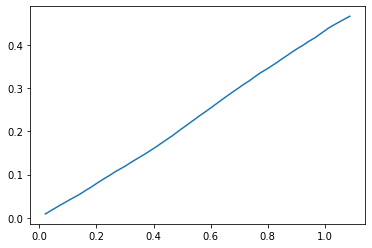

In [34]:
%matplotlib inline
plt.plot(b_pose[:,3].cpu().numpy(), b_pose[:,4].cpu().numpy())